<a class="anchor" id="top"></a>
**Formation Data Scientist - Projet 5**

**Segmentez des clients d'un site e-commerce**

**Partie 1 : Nettoyage et Exploration**

Antoine LEPAGE <br /> 
yop1001@gmail.com

https://openclassrooms.com/fr/projects/630/assignment

**Table des matières**


1. [Contexte](#contexte)<br /> 
<br /> 
2. [Librairies et fonctions](#librairies)<br /> 
<br /> 
3. [Importation des données](#importation)<br />
<br />
4. [Construction de l'échantillon des produits vendus](#echantillon_produits)<br />
<br />    
5. [Nettoyage](#nettoyage)<br />
    5.1. [Valeurs manquantes](#valeurs_manquantes)<br />
    5.2. [Vérification de la clef unique](#verif_primarykey)<br />
    5.3. [Inspection par variables](#inspection_variable)  
    5.3.1. [order_status](#order_status)<br />
    5.3.2. [order_id](#order_id)<br />
    5.3.3. [product_id](#product_id)<br />
    5.3.4. [seller_id](#seller_id)<br />
    5.3.5. [price](#price)<br />
    5.3.6. [freight_value](#freight_value)<br />
    5.3.7. [customer_id](#customer_id)<br />
    5.3.8. [order_purchase_timestamp and month](#order_purchase_timestamp)<br />
    5.3.9. [product_category_name_english](#product_category_name_english)<br />
    5.3.10. [customer_unique_id](#customer_unique_id)<br />
    5.3.11. [Location variables](#location)<br />
    5.3.12. [review_score](#review_score)<br />
    5.3.13. [comment](#comment)<br />
<br />   
6. [Construction de l'échantillon des clients](#echantillon_clients)<br />
<br />
7. [Construction des échantillons pour mesurer la maintenance](#echantillons_maintenance)<br />
<br />
8. [Exploration](#exploration)<br />
    8.1. [Etendue de l'étude](#etendue_etude)<br />
    8.2. [Chiffre d'Affaires](#CA)<br />
    8.3. [Etude des produits](#etude_produits)<br />
    8.4. [Etude des comportement clients](#etude_clients)<br />
    8.5. [Corrélations](#correlations)<br />
<br />      


<a class="anchor" id="contexte"></a>
# 1. Contexte 

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

**Les données**
Pour cette mission, Olist vous fournit une [base de données](https://www.kaggle.com/olistbr/brazilian-ecommerce)  anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.


**Votre mission**
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Enfin, votre client, Olist, a spécifié sa demande ainsi :
- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


**Inspiration**
Here are some inspiration for possible outcomes from this dataset.

- NLP: This dataset offers a supreme environment to parse out the reviews text through its multiple dimensions.
- Clustering: Some customers didn't write a review. But why are they happy or mad?
- Sales Prediction: With purchase date information you'll be able to predict future sales.
- Delivery Performance: You will also be able to work through delivery performance and find ways to optimize delivery times.
- Product Quality: Enjoy yourself discovering the products categories that are more prone to customer insatisfaction.
- Feature Engineering: Create features from this rich dataset or attach some external public information to it.



<a class="anchor" id="librairies"></a>
***
# 2. Librairies et fonctions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta
from IPython.display import IFrame


sns.set_style("whitegrid")
golden_brazil = '#FFDF00'

In [2]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
        #mis_val_table_ren_columns = mis_val_table_ren_columns[
        #    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        #'% of Total Values', ascending=False).round(1)
        #print ("Your selected dataframe has " + str(df.shape[1]) + " colfarumns.\n"      
        #    "There are " + str(mis_val_table_ren_columns.shape[0]) +
        #      " columns that have missing values.")
        return mis_val_table_ren_columns

In [3]:
def compute_data_customers(df):
    # Groupby customers
    data_customers = df[['price', 'customer_unique_id']].groupby(['customer_unique_id']).agg(['count', 'sum'])

    # Drop de la sur-colonne
    data_customers.columns = data_customers.columns.droplevel()

    # Rename
    data_customers.rename(columns={'count': 'nb_of_items_bought', 'sum': 'total_spent'}, inplace=True)

    # reset index
    data_customers = data_customers.reset_index()

    # verification
    data_customers['nb_of_items_bought'].sum()

    # Calculons le nombre de paniers par client
    baskets = df.groupby('customer_unique_id')['order_id'].nunique()
    baskets = baskets.reset_index()
    baskets.rename(columns={"order_id": "nb_of_baskets"}, inplace=True)
    
    # Ajoutons cette information au data_customers
    data_customers = data_customers.merge(baskets, on='customer_unique_id')
    

    # Calcul du nb moyen d'articles par panier par client
    data_customers['items_by_basket(mean)'] = data_customers['nb_of_items_bought'] / data_customers['nb_of_baskets']
    data_customers.sort_values(by=['nb_of_baskets'], ascending=False).head(10)


    # Frequence des achats
    data_temp = df.groupby('customer_unique_id')['order_purchase_timestamp'].agg(['max','min'])
    data_temp = data_temp.reset_index()
    data_temp.rename(columns={'max':'last_purchase','min':'oldest_purchase'}, inplace=True)
    
    # Calculons le nb de jour entre le premier et le dernier achat par client
    data_temp['time_length'] = data_temp['last_purchase'] - data_temp['oldest_purchase']
    
    # Ajoutons cette information au data_customers
    data_customers = data_customers.merge(data_temp[['customer_unique_id', 'time_length', 'oldest_purchase']], on='customer_unique_id')
    data_customers.head()

    # Calcul de l'ancienneté 
    data_customers['anciennete']  = df['order_purchase_timestamp'].max() - data_customers['oldest_purchase']

    # Convertir le timedelta en jour
    data_customers['anciennete'] = data_customers['anciennete'].dt.days

    # Calculons la frequence des achats 
    data_customers['purchase_frequency'] = data_customers['time_length']/(data_customers['nb_of_baskets']-1)
    data_customers.head()

    # Convertissons le purchase_frequency (timedelta) et un float 
    data_customers['mean_purchase_frequency(days)'] = data_customers['purchase_frequency']/timedelta(days=1)
    data_customers.loc[data_customers['purchase_frequency'].isnull(), 'td'] = 0

    # Calcul des dépenses par catégorie pour chaque client
    cat_by_customer = pd.pivot_table(df,index='customer_unique_id', values=["price"],
                   columns=["main_category"], aggfunc=[np.sum])

    # Suppression sur-colonne
    cat_by_customer.columns = cat_by_customer.columns.droplevel().droplevel()

    # Reset index
    cat_by_customer = cat_by_customer.fillna(0)

    # Ajoutons cette information au data_customers
    data_customers = data_customers.merge(cat_by_customer, on='customer_unique_id')
    data_customers.head()


    # Ajout des reviews
    mean_review_score_by_customer = df.groupby('customer_unique_id')['review_score'].mean()
    # Ajoutons cette information au data_customers
    data_customers = data_customers.merge(mean_review_score_by_customer, on='customer_unique_id')

    # Ajout du nombre de commentaires
    nb_of__review_by_customer = df.groupby('customer_unique_id')['comment'].sum()
    # Ajoutons cette information au data_customers
    data_customers = data_customers.merge(nb_of__review_by_customer, on='customer_unique_id')
    # rename
    data_customers.rename(columns={'comment': 'nb_of_comments'}, inplace=True)
    # calcul du % de commentaires
    data_customers['%_of_comments'] = (data_customers['nb_of_comments'] / data_customers['nb_of_items_bought'])*100

    # Ajout des données de géolocalisation
    data_temp = df.drop_duplicates(subset='customer_unique_id', keep='first', inplace=False)
    data_customers = data_customers.merge(data_temp[['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng']], on='customer_unique_id', how='left')

    # Ajout Nombre de vendeurs différents par clients 
    # Groupby commande
    number_of_sellers_by_customers = df.groupby('customer_unique_id')['seller_id'].nunique()

    # Sort
    number_of_sellers_by_customers.sort_values(ascending=False, inplace=True) 
    number_of_sellers_by_customers.rename("nb_of_sellers_used", inplace=True)


    # Ajout de l'information au data_customers
    data_customers = data_customers.merge(number_of_sellers_by_customers, on='customer_unique_id')

    # Ajout de l'indice 'fidelité aux vendeurs' (nombre de sellers different / nombre d'item achetes)
    data_customers['sellers_loyalty'] = 1 - (data_customers['nb_of_sellers_used'] / data_customers['nb_of_items_bought'])

    return data_customers

<a class="anchor" id="importation"></a>
***
# 3. Importation des données


![Image of Seattle Neighborhoods](https://i.imgur.com/HRhd2Y0.png)

- **olist_customers_dataset.csv** : This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location. At our system each order is assigned to a unique customer_id. This means that the same customer will get different ids for different orders. The purpose of having a customer_unique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.


- **olist_geolocation_dataset** : This dataset has information Brazilian zip codes and its lat/lng coordinates. Use it to plot maps and find distances between sellers and customers.


- **olist_order_items_dataset** This dataset includes data about the items purchased within each order.


- **olist_order_payments_dataset** This dataset includes data about the orders payment options.


- **olist_order_reviews_dataset** This dataset includes data about the reviews made by the customers.After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.


- **olist_orders_dataset** This is the core dataset. From each order you might find all other information.


- **olist_products_dataset** This dataset includes data about the products sold by Olist.


- **olist_sellers_dataset** This dataset includes data about the sellers that fulfilled orders made at Olist. Use it to find the seller location and to identify which seller fulfilled each product.


- **product_category_name_translation** Translates the product_category_name to english.


<br/>

**Datasets hors etude :**
- olist_order_payments_dataset
- olist_sellers_dataset

In [4]:
# Customers
customers = pd.read_csv('01 - Sources/olist_customers_dataset.csv', sep=',')
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [5]:
# Geoloc
geoloc = pd.read_csv('01 - Sources/olist_geolocation_dataset.csv', sep=',')
geoloc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [6]:
# Order_items
order_items = pd.read_csv('01 - Sources/olist_order_items_dataset.csv', sep=',')
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [7]:
# Reviews
reviews = pd.read_csv('01 - Sources/olist_order_reviews_dataset.csv', sep=',')
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [8]:
# Orders - core dataset
orders = pd.read_csv('01 - Sources/olist_orders_dataset.csv', sep=',')
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
# Products
products = pd.read_csv('01 - Sources/olist_products_dataset.csv', sep=',')
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [10]:
# Product category translation
cat_translation = pd.read_csv('01 - Sources/product_category_name_translation.csv', sep=',')
cat_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


<a class="anchor" id="echantillon_produits"></a>
***
# 4. Construction de l'échantillon des produits vendus


In [11]:
# On part des produits vendus
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [12]:
# On ne garde que les variables qui nous interessent
data = order_items[['order_id', 'product_id', 'seller_id', 'price', 'freight_value']]
data.head()

,order_id,product_id,seller_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14


In [13]:
data.shape

(112650, 5)

In [14]:
# On ajoute l'état de la commande, le client et la data d'achat
data = data.merge(orders, on='order_id')

# On ne garde que les variables utiles 
data = data[['order_id', 'product_id', 'seller_id', 
             'price', 'freight_value', 'customer_id', 
             'order_status', 'order_purchase_timestamp']]
data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51


In [15]:
data.shape

(112650, 8)

***


In [16]:
# Décomposition du timestamp

# Conversion en format date
data['order_purchase_timestamp']  = pd.to_datetime(data['order_purchase_timestamp']) 

# Ajout du mois d'achat pour étudier plus tard la saisonalité
data['month'] = pd.DatetimeIndex(data['order_purchase_timestamp']).month

# Ajout du jour de la semaine de la transaction
data['weekday_name'] = pd.DatetimeIndex(data['order_purchase_timestamp']).weekday_name

# Ajout de l'heure de la transaction
data['hour'] = pd.DatetimeIndex(data['order_purchase_timestamp']).hour

data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,4,Wednesday,10
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,1,Sunday,14
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,8,Wednesday,10
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2,Saturday,13


***


In [17]:
# On ajoute la catégorie du produit
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [18]:
data = data.merge(products[['product_id', 'product_category_name']], on='product_id')
data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff


In [19]:
data.shape

(112650, 12)

In [20]:
# Vérification si tous les produits ont une catégorie
data.loc[data['product_category_name'].isnull(), :].shape

(1603, 12)

In [21]:
# Suppression de ces produits
indexNames = data.loc[data['product_category_name'].isnull(), :].index
data.drop(indexNames , inplace=True)

In [22]:
data.shape

(111047, 12)

In [23]:
# On ajoute la traduction anglaise
cat_translation.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [24]:
data = data.merge(cat_translation, on='product_category_name')

# Suppression de la variable en portuguais
data.drop(['product_category_name'], axis=1, inplace=True)

data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff


In [25]:
data.shape

(111023, 12)

In [26]:
# Ajout des informations sur le client
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [27]:
data = data.merge(customers, on='customer_id')
data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG


In [28]:
data.shape

(111023, 16)

In [29]:
# Ajout de la geolocalisation du client
geoloc.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [30]:
# visualisation des valeurs de la variable
geoloc['geolocation_zip_code_prefix'].value_counts().head(10)

24220    1146
24230    1102
38400     965
35500     907
11680     879
22631     832
30140     810
11740     788
38408     773
28970     743
Name: geolocation_zip_code_prefix, dtype: int64

In [31]:
# On s'apercoit que pour un mm zipcode on peut avoir des lat et long différentes
# On elimine les doublons
geoloc = geoloc.drop_duplicates(subset='geolocation_zip_code_prefix', keep='first')

In [32]:
# On ajoute les latitudes et longitudes
data = data.merge(geoloc[['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng']], left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')

# On efface la colonne inutile
data.drop(['geolocation_zip_code_prefix'], axis=1, inplace=True)

data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837


In [33]:
data.shape

(111023, 18)

In [34]:
# Ajout de la note du client par commande et de son commentaire
data = data.merge(reviews[['order_id', 'review_score', 'review_comment_message']], on='order_id')
data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,review_comment_message
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,"Perfeito, produto entregue antes do combinado."
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,"lannister como sempre, entregou certinho e den..."
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,carrinho muito bonito
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,NaN
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,NaN


In [35]:
# # Ajoutons si la review est accompagnée d'un comment
data['comment'] = np.where(data['review_comment_message'].notnull(), 1, 0)

# Drop de la variable review_comment_message
data.drop(['review_comment_message'], axis=1, inplace=True)

data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0


In [36]:
data.shape

(111686, 20)

<a class="anchor" id="nettoyage"></a>
***
# 5. Nettoyage

<a class="anchor" id="valeurs_manquantes"></a>
## 5.1.  Valeurs manquantes

In [37]:
data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0


In [38]:
data.shape

(111686, 20)

In [39]:
missing_values_table(data)

,Missing Values,% of Missing Values
order_id,0,0.000000
product_id,0,0.000000
seller_id,0,0.000000
price,0,0.000000
freight_value,0,0.000000
customer_id,0,0.000000
order_status,0,0.000000
order_purchase_timestamp,0,0.000000
month,0,0.000000
weekday_name,0,0.000000


In [40]:
# Sauvegarde dans un autre df des informations manquantes
data_temp = data.loc[data['geolocation_lat'].isnull()]
data_temp.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment
294,b73c273d02a8045c60df03ae7c03dc4b,601a360bd2a916ecef0e88de72a6531a,7a67c85e85bb2ce8582c35f2203ad736,129.99,29.31,7aea4c1a850cf1f179099fa1c85e9c51,delivered,2017-07-05 22:24:44,7,Wednesday,22,cool_stuff,b5baa582db90d336a8a7a88fb6598a9e,56485,tacaratu,PE,NaN,NaN,1,1
1109,26d50e2b2072855e670311f1aa623f86,f83c9874b5b5044ea58fef1be68c1ea8,2e90cb1677d35cfe24eef47d441b7c87,132.70,25.68,92bc8ba533fd5f3a2c5fb8c16f6f9611,delivered,2017-05-10 20:54:15,5,Wednesday,20,cool_stuff,2991185ed4a275b32b09338ebc32a7f9,72005,brasilia,DF,NaN,NaN,4,0
1888,0acce7378714d20548f0f5f1b71f6458,bcd58b852a3b0152b6b384c4e4474ba2,8b321bb669392f5163d04c59e235e066,125.00,17.12,5b310d1f78f27de30f2fb3ddbc5e8a49,delivered,2017-12-30 21:48:24,12,Saturday,21,cool_stuff,b9c201d679a0f0fbae1f2b9620b3155a,70701,brasilia,DF,NaN,NaN,4,1
1944,6f67990385ad635034062e653f7e6493,62644f19deb898e43ebdcd29ff3d9361,dd55f1bb788714a40e7954c3be6df745,243.89,16.47,a9e435c5800dffb292605fcedaf69574,delivered,2017-12-18 23:46:06,12,Monday,23,cool_stuff,12c4f7b676e61f23f3520f2196fe16e3,70686,brasilia,DF,NaN,NaN,5,0
2264,7a0b657901f79cf17980c043f9536dcf,4a69baa66a13d1adeb41cfe3bc0c27be,bbad7e518d7af88a0897397ffdca1979,99.90,15.46,c7201484ae70fbceb803edabe73f85d2,delivered,2017-08-26 21:37:39,8,Saturday,21,cool_stuff,3264bdf15cdf919688dcf64636e55437,71539,brasilia,DF,NaN,NaN,2,0


In [41]:
data_temp.shape

(301, 20)

301 zipcodes n'ont pas matché lors du merge sur les zipcode. On peut effectuer un deuxieme merge sur le nom de la ville (moins précis mais c'est deja ca)

In [42]:
# On enlève ces 301 lignes du dataframe principal
indexNames = data.loc[data['geolocation_lat'].isnull()].index
data.drop(indexNames , inplace=True)

In [43]:
data.shape

(111385, 20)

***

In [44]:
# On elimine les doublons en se basant sur les villes
geoloc_2 = geoloc.drop_duplicates(subset='geolocation_city', keep='first')

In [45]:
geoloc_2.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
5,1012,-23.547762,-46.635361,são paulo,SP
148126,6036,-23.559508,-46.775873,osasco,SP
155785,6382,-23.548111,-46.841167,carapicuíba,SP
155786,6342,-23.583614,-46.823485,carapicuiba,SP


In [46]:
# On ajoute les lat et longitude au data_temp en se basant sur les villes
data_temp = data_temp.merge(geoloc_2[['geolocation_lat', 'geolocation_lng', 'geolocation_city']], left_on='customer_city', right_on='geolocation_city', how='left')

# On efface les colonnes inutiles
data_temp.drop(['geolocation_lat_x', 'geolocation_lng_x', 'geolocation_city'], axis=1, inplace=True)

# On renomme les colonnes
data_temp.rename(columns={"geolocation_lat_y": "geolocation_lat", "geolocation_lng_y": "geolocation_lng"}, inplace=True)

data_temp.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_score,comment,geolocation_lat,geolocation_lng
0,b73c273d02a8045c60df03ae7c03dc4b,601a360bd2a916ecef0e88de72a6531a,7a67c85e85bb2ce8582c35f2203ad736,129.99,29.31,7aea4c1a850cf1f179099fa1c85e9c51,delivered,2017-07-05 22:24:44,7,Wednesday,22,cool_stuff,b5baa582db90d336a8a7a88fb6598a9e,56485,tacaratu,PE,1,1,-9.106290,-38.149797
1,26d50e2b2072855e670311f1aa623f86,f83c9874b5b5044ea58fef1be68c1ea8,2e90cb1677d35cfe24eef47d441b7c87,132.70,25.68,92bc8ba533fd5f3a2c5fb8c16f6f9611,delivered,2017-05-10 20:54:15,5,Wednesday,20,cool_stuff,2991185ed4a275b32b09338ebc32a7f9,72005,brasilia,DF,4,0,-15.790439,-47.880655
2,0acce7378714d20548f0f5f1b71f6458,bcd58b852a3b0152b6b384c4e4474ba2,8b321bb669392f5163d04c59e235e066,125.00,17.12,5b310d1f78f27de30f2fb3ddbc5e8a49,delivered,2017-12-30 21:48:24,12,Saturday,21,cool_stuff,b9c201d679a0f0fbae1f2b9620b3155a,70701,brasilia,DF,4,1,-15.790439,-47.880655
3,6f67990385ad635034062e653f7e6493,62644f19deb898e43ebdcd29ff3d9361,dd55f1bb788714a40e7954c3be6df745,243.89,16.47,a9e435c5800dffb292605fcedaf69574,delivered,2017-12-18 23:46:06,12,Monday,23,cool_stuff,12c4f7b676e61f23f3520f2196fe16e3,70686,brasilia,DF,5,0,-15.790439,-47.880655
4,7a0b657901f79cf17980c043f9536dcf,4a69baa66a13d1adeb41cfe3bc0c27be,bbad7e518d7af88a0897397ffdca1979,99.90,15.46,c7201484ae70fbceb803edabe73f85d2,delivered,2017-08-26 21:37:39,8,Saturday,21,cool_stuff,3264bdf15cdf919688dcf64636e55437,71539,brasilia,DF,2,0,-15.790439,-47.880655


In [47]:
# On concatene les deux dataframes pour retrouver le df initial avec toutes les informations
data = data.append(data_temp, ignore_index=True, sort=False)
data.shape

(111686, 20)

In [48]:
# verification
missing_values_table(data)

,Missing Values,% of Missing Values
order_id,0,0.000000
product_id,0,0.000000
seller_id,0,0.000000
price,0,0.000000
freight_value,0,0.000000
customer_id,0,0.000000
order_status,0,0.000000
order_purchase_timestamp,0,0.000000
month,0,0.000000
weekday_name,0,0.000000


In [49]:
# Encore 49 produits sans geoloc car ville non trouvée.
data.loc[data['geolocation_lat'].isnull()].head(10)

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment
111393,7c42aafccecb4aefc0c0b345114cb321,ff81cd23251a357a120054397a01849f,4cf490a58259286ada5ba8525ba9e84a,178.90,36.57,e6add8f4805cb6a382c26548daaed9d7,delivered,2017-11-06 00:27:44,11,Monday,0,cool_stuff,6c9871f7c55b411fabb59d9130b51e6d,65830,sambaiba,MA,NaN,NaN,1,1
111411,389a2342cf14ac39a661c9b08a3cdfa6,a5e130225bfc3dde1f8ec32d8c37b66d,1025f0e2d44d7041d6cf58b6550e0bfa,32.00,16.11,cdc2bba36d83fe46dea8a0dce9453146,delivered,2017-10-26 12:52:24,10,Thursday,12,furniture_decor,d36c4833ff5369ed3c7225ee636fbeb8,25840,bemposta,RJ,NaN,NaN,5,0
111418,009fa9bd0d92710e840793bfefa80867,617186c3d97ea56c9c683a8a3974e8c1,cc419e0650a3c5ba77189a1882b7556a,84.99,15.34,ed19fa6ce948d52be769926c2baaa17c,delivered,2017-06-14 09:44:30,6,Wednesday,9,perfumery,0124721bc33e0aa6772b42d4ccfd01db,38710,major porto,MG,NaN,NaN,4,0
111419,8734071c7bfc4d453e59546b22c5ce0e,ee0c1cf2fbeae95205b4aa506f1469f0,cc419e0650a3c5ba77189a1882b7556a,53.99,21.18,78bebfa74709728a62d4a98efbde8ac0,delivered,2017-10-07 09:50:07,10,Saturday,9,perfumery,fac8b5e914037fc2e2476783585f0769,65137,maioba,MA,NaN,NaN,1,1
111422,7bac1567c0592387d6b83a189f7d25ef,473795a355d29305c3ea6b156833adf5,620c87c171fb2a6dd6e8bb4dec959fc6,55.90,16.83,4a5642b29f7d0885758928dc7ec35909,delivered,2018-02-14 17:25:43,2,Wednesday,17,perfumery,04f08b09dd9ae5d658be400b1b786c47,75784,domiciano ribeiro,GO,NaN,NaN,4,0
111425,690199d6a2c51ff57c6b392d7680cbfd,75d6b6963340c6063f7f4cfcccfe6a30,cc419e0650a3c5ba77189a1882b7556a,54.99,18.26,19bacb562bd43bd4eaf05b6c0a59dad0,delivered,2018-03-16 11:31:18,3,Friday,11,perfumery,c5f01991eadc43c924dfd891e9026217,87323,alto sao joao,PR,NaN,NaN,5,0
111436,675ea662391ef609e39645b25940d453,389d119b48cf3043d311335e499d9c6b,1f50f920176fa81dab994f9023523100,59.90,17.67,7d643c6504deebe6d2ab830865d71584,delivered,2017-11-08 18:44:44,11,Wednesday,18,garden_tools,24abf93a73a57ab3fe56df52deb2c6c5,36857,pinhotiba,MG,NaN,NaN,5,0
111440,51e827dc634ca855acba1d305c4649af,0c8862859cb952ee81428f80dc8140d9,f2336e113377dd21c744d9c4fc8293a9,1199.00,66.83,dcef2fe349300ac52c962eb0f0fbc453,delivered,2017-09-15 13:18:29,9,Friday,13,garden_tools,9eceb9f7c2bd232366d8b271461849c0,58734,passagem,PB,NaN,NaN,5,1
111442,9975d8efcc8e0ffd4ebb4b3d16592110,0a8038344359ff23c26156650b801e6c,2199e7fe213c16213bf5d6a7eadc9a5d,157.90,13.45,e76656ce4486a41da00e471277b1d1e9,delivered,2017-06-16 00:18:25,6,Friday,0,garden_tools,acca556e877c4ee6aaa815349925fab6,17390,sao sebastiao da serra,SP,NaN,NaN,5,0
111443,f92c4415380d5956969e7b44174a6476,76f4e994b24c20555320f08cf10d28bb,989becdce12ebc39863c2bceab6f3ca1,25.00,22.11,786cc4eab38165553b0fb0c53a35817a,delivered,2018-07-26 19:28:07,7,Thursday,19,garden_tools,9762e6c31b598116ac89680124fe173e,39103,guinda,MG,NaN,NaN,5,0


In [50]:
# Suppression de ces 49 produits
indexNames = data.loc[data['geolocation_lat'].isnull()].index
data.drop(indexNames , inplace=True)

In [51]:
# verification
missing_values_table(data)

,Missing Values,% of Missing Values
order_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
price,0,0.0
freight_value,0,0.0
customer_id,0,0.0
order_status,0,0.0
order_purchase_timestamp,0,0.0
month,0,0.0
weekday_name,0,0.0


In [52]:
data.shape

(111637, 20)

<a class="anchor" id="verif_primarykey"></a>
***
## 5.2.  Vérification de la clef unique

In [53]:
# Compter le nombre de 'code' en doublon
data['order_id'].duplicated(keep=False).sum()

24550

Nous n'avons pas de clef unique

<a class="anchor" id="inspection_variable"></a>
***
## 5.3. Inspection par variable

In [54]:
data.head()

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,30407a72ad8b3f4df4d15369126b20c9,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,91a792fef70ecd8cc69d3c7feb3d12da,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0


In [55]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111637 entries, 0 to 111685
Data columns (total 20 columns):
order_id                         111637 non-null object
product_id                       111637 non-null object
seller_id                        111637 non-null object
price                            111637 non-null float64
freight_value                    111637 non-null float64
customer_id                      111637 non-null object
order_status                     111637 non-null object
order_purchase_timestamp         111637 non-null datetime64[ns]
month                            111637 non-null int64
weekday_name                     111637 non-null object
hour                             111637 non-null int64
product_category_name_english    111637 non-null object
customer_unique_id               111637 non-null object
customer_zip_code_prefix         111637 non-null int64
customer_city                    111637 non-null object
customer_state                   111637 no

In [56]:
data.describe()

,price,freight_value,month,hour,customer_zip_code_prefix,geolocation_lat,geolocation_lng,review_score,comment
count,111637.000000,111637.000000,111637.000000,111637.000000,111637.000000,111637.000000,111637.000000,111637.000000,111637.000000
mean,120.578635,20.011304,6.030599,14.754445,35108.904055,-21.224584,-46.203684,4.018274,0.428496
std,183.013342,15.815269,3.227945,5.313270,29859.381988,5.578452,4.043149,1.397721,0.494863
min,0.850000,0.000000,1.000000,0.000000,1003.000000,-36.605374,-72.666706,1.000000,0.000000
25%,39.900000,13.080000,3.000000,11.000000,11310.000000,-23.589946,-48.105099,4.000000,0.000000
50%,74.900000,16.290000,6.000000,15.000000,24322.000000,-22.929319,-46.633830,5.000000,0.000000
75%,134.900000,21.180000,8.000000,19.000000,59020.000000,-20.147537,-43.642049,5.000000,1.000000
max,6735.000000,409.680000,12.000000,23.000000,99980.000000,42.184003,-8.577855,5.000000,1.000000


<a class="anchor" id="order_status"></a>
***
### 5.3.1. order_status

In [57]:
# order_id des valeurs de la variable
data['order_status'].value_counts().head(10)

delivered      109234
shipped          1168
canceled          530
invoiced          352
processing        343
unavailable         7
approved            3
Name: order_status, dtype: int64

In [58]:
data.shape

(111637, 20)

In [59]:
# Supprimons les produits pour lesquels la vente n'a pas aboutie canceled é unavailable
indexNames = data.loc[(data['order_status'] == 'canceled') | (data['order_status'] == 'unavailable')].index
data.drop(indexNames , inplace=True)

# Vérification
data.shape

(111100, 20)

<a class="anchor" id="order_id"></a>
***
### 5.3.2. order_id

In [60]:
# order_id des valeurs de la variable
data['order_id'].value_counts().head(10)

5a3b1c29a49756e75f1ef513383c0c12    22
8272b63d03f5f79c56e9e4120aec44ef    21
1b15974a0141d54e36626dca3fdc731a    20
ab14fdcfbe524636d65ee38360e22ce8    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
73c8ab38f07dc94389065f7eba4f297a    14
9bdc4d4c71aa1de4606060929dee888c    14
37ee401157a3a0b28c9c6d0ed8c3b24b    13
3a213fcdfe7d98be74ea0dc05a8b31ae    12
Name: order_id, dtype: int64

In [61]:
# Nombre de commandes
data['order_id'].unique().size

96756

Il y a 97 256 commandes pour l'ensemble. La plus grande comprend 21 produits et la plus petite 1 seul.

<a class="anchor" id="product_id"></a>
***
### 5.3.3. product_id

In [62]:
# order_id des valeurs de la variable
data['product_id'].value_counts().head(10)

aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    490
422879e10f46682990de24d770e7f83d    487
368c6c730842d78016ad823897a372db    391
389d119b48cf3043d311335e499d9c6b    390
53759a2ecddad2bb87a079a1f1519f73    375
d1c427060a0f73f6b889a5c7c61f2ac4    341
53b36df67ebb7c41585e8d54d6772e08    323
154e7e31ebfa092203795c972e5804a6    292
3dd2a17168ec895c781a9191c1e95ad7    274
Name: product_id, dtype: int64

In [63]:
# Nombre de produits unique
data['product_id'].unique().size

32105

Il y a 32105 produits uniques commandés. Le plus commandé l'a été 527 fois!

<a class="anchor" id="seller_id"></a>
***
### 5.3.4. seller_id

In [64]:
# order_id des valeurs de la variable
data['seller_id'].value_counts().head(10)

6560211a19b47992c3666cc44a7e94c0    2031
4a3ca9315b744ce9f8e9374361493884    2006
1f50f920176fa81dab994f9023523100    1938
cc419e0650a3c5ba77189a1882b7556a    1805
da8622b14eb17ae2831f4ac5b9dab84a    1574
955fee9216a65b617aa5c0531780ce60    1499
1025f0e2d44d7041d6cf58b6550e0bfa    1442
7c67e1448b00f6e969d365cea6b010ab    1374
ea8482cd71df3c1969d7b9473ff13abc    1203
7a67c85e85bb2ce8582c35f2203ad736    1174
Name: seller_id, dtype: int64

In [65]:
# Nombre de produits unique
data['seller_id'].unique().size

2990

Il y a 2990 vendeurs differents qui ont vendus sur Olist. Le meilleur a vendu 2025 produits

In [66]:
# Des vendeurs différents peuvent ils vendre le meme produit ?
data_by_product_1 = data[['product_id', 'seller_id']].groupby('product_id').agg(['count'])
data_by_product_1.head(10)

,seller_id
,count
product_id,
00066f42aeeb9f3007548bb9d3f33c38,1
00088930e925c41fd95ebfe695fd2655,1
0009406fd7479715e4bef61dd91f2462,1
000b8f95fcb9e0096488278317764d19,2
000d9be29b5207b54e86aa1b1ac54872,1
0011c512eb256aa0dbbb544d8dffcf6e,1
00126f27c813603687e6ce486d909d01,2
001795ec6f1b187d37335e1c4704762e,9


Oui. Ce qui parait normal

<a class="anchor" id="price"></a>
***
### 5.3.5. price

In [67]:
data['price'].max()

6735.0

In [68]:
data['price'].min()

0.85

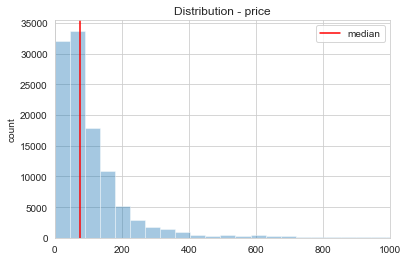

In [69]:
# Distribution de la variable
sns.distplot(data['price'], kde=False, bins=150)
plt.axvline(data['price'].median(), color='red', linestyle='-', label='median')

plt.title('Distribution - price')
plt.xlabel('')
plt.ylabel('count')
plt.xlim(0,1000)
plt.legend()

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Distribution - price.png', dpi=200, bbox_inches='tight')
plt.show()

Les prix des produits vendus oscillent entre 0.85 et 6735 réals. 
Le nombre de produits les plus vendus sont dans la classe 50-100 réals

***

In [70]:
# Un meme produit peut il avoir des prix différents ? 
data_by_product_2 = data[['product_id', 'price']].groupby('product_id').agg(['min', 'max'])
data_by_product_2.head()

price        
                                     min     max
product_id                                      
00066f42aeeb9f3007548bb9d3f33c38  101.65  101.65
00088930e925c41fd95ebfe695fd2655  129.90  129.90
0009406fd7479715e4bef61dd91f2462  229.00  229.00
000b8f95fcb9e0096488278317764d19   58.90   58.90
000d9be29b5207b54e86aa1b1ac54872  199.00  199.00

In [71]:
# Vérifions si les colonnes sont différentes :
data_by_product_2['diff'] = np.where((data_by_product_2[('price','min')] != data_by_product_2[('price','max')]), 'not ok', 'ok')
data_by_product_2.head()

price         diff
                                     min     max     
product_id                                           
00066f42aeeb9f3007548bb9d3f33c38  101.65  101.65   ok
00088930e925c41fd95ebfe695fd2655  129.90  129.90   ok
0009406fd7479715e4bef61dd91f2462  229.00  229.00   ok
000b8f95fcb9e0096488278317764d19   58.90   58.90   ok
000d9be29b5207b54e86aa1b1ac54872  199.00  199.00   ok

In [72]:
# comptabilisons le nombre de produits qui ont des prix différents
data_by_product_2.loc[data_by_product_2['diff'] == 'not ok'].size

17433

In [73]:
data_by_product_2.loc[data_by_product_2['diff'] == 'not ok'].head()

price            diff
                                     min     max        
product_id                                              
00210e41887c2a8ef9f791ebc780cc36   32.98   33.99  not ok
002159fe700ed3521f46cfcf6e941c76  199.70  220.70  not ok
00250175f79f584c14ab5cecd80553cd   54.99   79.99  not ok
005030ef108f58b46b78116f754d8d38   13.99   18.99  not ok
007c63ae4b346920756b5adcad8095de   71.00   79.99  not ok

Un meme produit peut avoir des prix différent. Ce qui parait normal car il y a des vendeurs différents et les prix évoluent dans le temps

<a class="anchor" id="freight_value"></a>
***
### 5.3.6. freight_value

In [74]:
data['freight_value'].max()

409.68

In [75]:
data.sort_values(by=['freight_value'], ascending=False)

,order_id,product_id,seller_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment
85093,a77e1550db865202c56b19ddc6dc4d53,ec31d2a17b299511e7c8627be9337b9b,257e61d3251fb5efb9daadddbc2cf7ca,979.00,409.68,4eed76c1aafeceac4250e202ca9b1a5a,delivered,2018-04-16 14:57:21,4,Monday,14,baby,97734fdca127fddcb5f92f841690c3f2,64770,sao raimundo nonato,PI,-9.016731,-42.688320,5,0
23927,3fde74c28a3d5d618c00f26d51baafa0,a3cd9517ebf5a50dca25acce54f3b171,6fa9202c10491e472dffd59a3e82b2a3,2338.08,375.28,f2c743697f9b2ff2902df23a16582d80,delivered,2018-08-13 14:07:50,8,Monday,14,housewares,5e92460d739e8dd987e279285a1d278c,88053,florianopolis,SC,-27.442081,-48.483449,5,0
23926,076d1555fb53a89b0ef4d529e527a0f6,a3cd9517ebf5a50dca25acce54f3b171,6fa9202c10491e472dffd59a3e82b2a3,2338.08,375.28,f08306b95370e8d5f0d97b71229284b6,delivered,2018-07-30 10:04:21,7,Monday,10,housewares,f140f377d666848e3712b51a2734d120,87013,maringa,PR,-23.419864,-51.937051,4,1
28506,9f49bd16053df810384e793386312674,256a9c364b75753b97bee410c9491ad8,5c030029b5916fed0986310385ec9009,1149.00,339.59,98ef9188ce9357bd77f60150a935c7fb,delivered,2018-07-29 11:41:33,7,Sunday,11,housewares,c6f70f6262d971489361b0d4fb0936ed,12460,campos do jordao,SP,-22.732323,-45.564270,4,0
39472,264a7e199467906c0727394df82d1a6a,97c948ebc8c04b26b7bbb095d4228f2a,17f51e7198701186712e53a39c564617,1050.00,338.30,9913942a9bd26b840c4d19db0cbf6b89,delivered,2018-04-06 17:20:33,4,Friday,17,health_beauty,5f2f6fba74de007241fedfc485b72ba7,78500,colider,MT,-10.813165,-55.457305,5,0
39474,c7a07ddd52bbe18b61da49a8d89853d3,97c948ebc8c04b26b7bbb095d4228f2a,17f51e7198701186712e53a39c564617,1050.00,322.10,1107a610c5e1caae0ff024795cdefb73,delivered,2018-07-13 10:33:48,7,Friday,10,health_beauty,0820b88e46f48599042bd627fe954b66,36160,guarani,MG,-21.357815,-43.049327,5,0
38153,0b6230647ed16f4b3e70282dc4b5b87f,46e24ce614899e36617e37ea1e4aa6ff,17f51e7198701186712e53a39c564617,1050.00,321.88,a86efb07b29b0ab31a5c6047c600edab,delivered,2018-05-16 13:05:37,5,Wednesday,13,health_beauty,ecf7874aa8a2586adf6ca37fab21ecc2,29303,cachoeiro de itapemirim,ES,-20.855568,-41.114712,2,1
81159,0822bcde10bb5d023755a71bc8f7797f,363a9f5b97bf194da23858be722a7aa5,9596c870880d900012f2e8e6e30d06d7,990.00,321.46,6bdf92e9fc8278f946ab67d15ebfe4ff,delivered,2018-05-07 23:29:24,5,Monday,23,construction_tools_construction,e3b3b57caa0974d93ed5218dde2ff4b3,2307,sao paulo,SP,-23.482875,-46.608005,4,0
92388,43bdbd9dc0931d72befdf4765af6c442,7e53e051875b2a0c9f22acd8a9a29a20,eeb6de78f79159600292e314a77cbd18,3089.00,317.47,3c7c62e8d38fb18a33a45db8021f2d69,delivered,2018-07-06 11:07:02,7,Friday,11,industry_commerce_and_business,95a744604de66a2e40e18086e69be4f2,58041,joao pessoa,PB,-7.120710,-34.853359,5,0
81160,6ddfbf514959b49b6410c01ad93054bb,363a9f5b97bf194da23858be722a7aa5,9596c870880d900012f2e8e6e30d06d7,1045.00,314.40,48c4bc0a9a1ef619c41c102912dbf1a0,delivered,2017-11-23 15:10:22,11,Thursday,15,construction_tools_construction,aa4e2575d36a7b89546ca2e4087e9396,57045,maceio,AL,-9.619389,-35.714263,4,0


In [76]:
data['freight_value'].min()

0.0

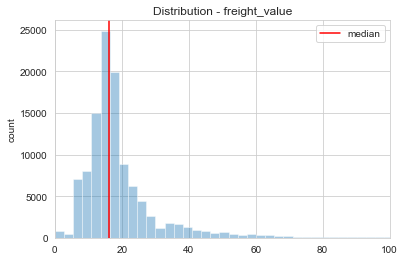

In [77]:
# Distribution de la variable
sns.distplot(data['freight_value'], kde=False, bins=150)
plt.axvline(data['freight_value'].median(), color='red', linestyle='-', label='median')

plt.title('Distribution - freight_value')
plt.xlabel('')
plt.ylabel('count')
plt.xlim(0,100)
plt.legend()

#plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/number of floors.png', dpi=200, bbox_inches='tight')
plt.show()

***

In [78]:
# Un meme produit peut il avoir des freight_value différents ? 
data_by_product_3 = data[['product_id', 'freight_value']].groupby('product_id').agg(['min', 'max'])
data_by_product_3.head()

freight_value       
                                           min    max
product_id                                           
00066f42aeeb9f3007548bb9d3f33c38         18.59  18.59
00088930e925c41fd95ebfe695fd2655         13.93  13.93
0009406fd7479715e4bef61dd91f2462         13.10  13.10
000b8f95fcb9e0096488278317764d19         19.60  19.60
000d9be29b5207b54e86aa1b1ac54872         19.27  19.27

In [79]:
# Vérifions si les colonnes sont différentes :
data_by_product_3['diff'] = np.where((data_by_product_3[('freight_value','min')] != data_by_product_3[('freight_value','max')]), 'not ok', 'ok')
data_by_product_3.head()

freight_value        diff
                                           min    max     
product_id                                                
00066f42aeeb9f3007548bb9d3f33c38         18.59  18.59   ok
00088930e925c41fd95ebfe695fd2655         13.93  13.93   ok
0009406fd7479715e4bef61dd91f2462         13.10  13.10   ok
000b8f95fcb9e0096488278317764d19         19.60  19.60   ok
000d9be29b5207b54e86aa1b1ac54872         19.27  19.27   ok

In [80]:
# comptabilisons le nombre de produits qui ont des prix différents
data_by_product_3.loc[data_by_product_3['diff'] == 'not ok'].size

36945

In [81]:
data_by_product_3.loc[data_by_product_2['diff'] == 'not ok'].head()

freight_value           diff
                                           min    max        
product_id                                                   
00210e41887c2a8ef9f791ebc780cc36          8.27  15.10  not ok
002159fe700ed3521f46cfcf6e941c76         18.65  57.95  not ok
00250175f79f584c14ab5cecd80553cd          9.09  15.31  not ok
005030ef108f58b46b78116f754d8d38          7.39  21.15  not ok
007c63ae4b346920756b5adcad8095de         11.76  23.06  not ok

Un meme produit peut avoir des frais d'expedition différent. Ce qui parait normal

<a class="anchor" id="customer_id"></a>
***
### 5.3.7. customer_id

customer_idkey to the orders dataset. Each order has a unique customer_id.

N'apporte aucune information supplémentaire. Ne sert qu'à faire le lien avec customer_unique_id qui a déja été fait

In [82]:
# Suppression de la colonne
data.drop(['customer_id'], axis=1, inplace=True)

<a class="anchor" id="order_purchase_timestamp"></a>
***
### 5.3.8. order_purchase_timestamp and month

In [83]:
# date en index
data.index = data['order_purchase_timestamp'] 

data.head()

,order_id,product_id,seller_id,price,freight_value,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment
order_purchase_timestamp,,,,,,,,,,,,,,,,,,,
2017-09-13 08:59:02,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1
2017-06-28 11:52:20,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1
2018-05-18 10:25:53,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1
2017-08-01 18:38:42,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0
2017-08-10 21:48:40,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0


In [84]:
# Regroupement des commandes par mois
data_by_month = data['price'].resample('M').agg(['count', 'sum'])
data_by_month

,count,sum
order_purchase_timestamp,,
2016-09-30,5,207.86
2016-10-31,345,44968.09
2016-11-30,0,0.00
2016-12-31,1,10.90
2017-01-31,951,119170.66
2017-02-28,1889,237185.25
2017-03-31,2930,362957.54
2017-04-30,2595,345686.87
2017-05-31,4051,495184.46


In [85]:
# Nous effacons la dernière transaction du mois de septembre
indexNames = data.loc[data['order_purchase_timestamp'] == data['order_purchase_timestamp'].max()].index
data.drop(indexNames , inplace=True)

# actualisons data_by_month
data_by_month = data['price'].resample('M').agg(['count', 'sum'])

data.shape

(111099, 19)

Nous avons les données de Olist de septembre 2016 a aout 2018.

**Les mois 09/2016, 11/2016, 12/2016 et présentent très peu de ventes. Ce qui parait très étonnant**

***

In [86]:
# Distribution des ventes par mois
sells_by_month = data['month'].value_counts()
sells_by_month

8     12038
5     11913
7     11478
3     11029
6     10579
4     10486
2      9463
1      8971
11     8564
12     6182
10     5617
9      4779
Name: month, dtype: int64

In [87]:
# Distribution des ventes par jour de la semaine
sells_by_weekday_name = data['weekday_name'].value_counts()
sells_by_weekday_name

Monday       18131
Tuesday      17966
Wednesday    17349
Thursday     16565
Friday       15864
Sunday       13222
Saturday     12002
Name: weekday_name, dtype: int64

In [88]:
# Distribution des ventes par heure
sells_by_hour = data['hour'].value_counts()
sells_by_hour 

16    7527
14    7463
11    7327
13    7302
15    7288
10    6938
17    6911
21    6811
20    6806
12    6718
19    6625
18    6461
22    6456
9     5345
23    4596
8     3354
0     2675
7     1353
1     1270
2      573
6      543
3      309
4      243
5      205
Name: hour, dtype: int64

<a class="anchor" id="product_category_name_english"></a>
***
### 5.3.9. product_category_name_english

In [89]:
# Valeurs de la variable
data['product_category_name_english'].value_counts()

bed_bath_table                           11250
health_beauty                             9687
sports_leisure                            8647
furniture_decor                           8378
computers_accessories                     7848
housewares                                6940
watches_gifts                             5978
telephony                                 4529
garden_tools                              4338
auto                                      4220
toys                                      4088
cool_stuff                                3788
perfumery                                 3414
baby                                      3050
electronics                               2756
stationery                                2510
fashion_bags_accessories                  2042
pet_shop                                  1944
office_furniture                          1698
consoles_games                            1128
luggage_accessories                       1086
construction_

In [90]:
# Nombre de catégories de produit
len(data['product_category_name_english'].value_counts())

71

In [91]:
# Liste
data['product_category_name_english'].unique()

array(['cool_stuff', 'baby', 'bed_bath_table', 'computers_accessories',
       'watches_gifts', 'toys', 'consoles_games', 'furniture_decor',
       'sports_leisure', 'books_general_interest',
       'construction_tools_safety', 'telephony', 'housewares',
       'home_construction', 'health_beauty', 'tablets_printing_image',
       'auto', 'cine_photo', 'pet_shop', 'garden_tools', 'perfumery',
       'construction_tools_construction', 'costruction_tools_garden',
       'food', 'books_technical', 'stationery', 'furniture_bedroom',
       'art', 'musical_instruments', 'construction_tools_lights',
       'office_furniture', 'kitchen_dining_laundry_garden_furniture',
       'furniture_living_room', 'home_confort',
       'industry_commerce_and_business', 'computers', 'electronics',
       'market_place', 'small_appliances', 'flowers', 'music',
       'la_cuisine', 'luggage_accessories', 'arts_and_craftmanship',
       'food_drink', 'drinks', 'dvds_blu_ray', 'fixed_telephony',
       'fashio

In [92]:
# On regroupe les 71 catégories en 17 catégories principales (fait à la main)

# Import de la table de correspondance
cat_correspondence = pd.read_excel('01 - Sources/categories_correspondence.xlsx')

# Merge des 2 tables
data = data.merge(cat_correspondence, on='product_category_name_english')

data.head()

,order_id,product_id,seller_id,price,freight_value,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment,main_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1,Cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1,Cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1,Cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0,Cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0,Cool_stuff


In [93]:
# Valeurs de la variable
data['main_category'].value_counts()

Home          28769
Hygiene       13139
High-Tech     12018
Leisure        8647
Fashion        8634
Kid's          7181
Tools          6098
Telephony      4791
Auto           4220
Cool_stuff     3788
Stationery     2510
Other          2150
Appliances     2090
Culture        2022
Pet-Shop       1944
Furniture      1698
Food           1168
Art             232
Name: main_category, dtype: int64

<a class="anchor" id="customer_unique_id"></a>
***
### 5.3.10. customer_unique_id

In [94]:
data.head()

,order_id,product_id,seller_id,price,freight_value,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment,main_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1,Cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1,Cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1,Cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0,Cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0,Cool_stuff


In [95]:
# Nombre de clients uniques 
len(data['customer_unique_id'].unique())

93616

<a class="anchor" id="location"></a>
***
### 5.3.11. Location variables

In [96]:
# Valeurs de la variable - customer_zip_code_prefix
data['customer_zip_code_prefix'].value_counts().head(10)

22790    150
22793    148
24220    143
24230    134
22775    122
29101    112
35162    110
11740    106
13087    105
22631    103
Name: customer_zip_code_prefix, dtype: int64

In [97]:
# Valeurs de la variable - customer_city
data['customer_city'].value_counts().head(10)

sao paulo                17502
rio de janeiro            7725
belo horizonte            3100
brasilia                  2378
curitiba                  1732
campinas                  1630
porto alegre              1591
salvador                  1391
guarulhos                 1304
sao bernardo do campo     1042
Name: customer_city, dtype: int64

In [98]:
# Valeurs de la variable - customer_state
data['customer_state'].value_counts().head(10)

SP    46760
RJ    14362
MG    12957
RS     6161
PR     5657
SC     4114
BA     3740
DF     2391
GO     2287
ES     2240
Name: customer_state, dtype: int64

In [99]:
# Valeurs de la variable
data['geolocation_lat'].value_counts().head(10)

-15.790439    185
-23.011335    150
-23.009271    148
-22.905817    143
-22.911270    134
-22.972957    122
-20.331613    112
-19.478096    110
-24.149651    106
-22.852758    105
Name: geolocation_lat, dtype: int64

In [100]:
data['geolocation_lat'].min()

-36.6053744107061

In [101]:
data['geolocation_lat'].max()

42.18400274298598

In [102]:
# Valeurs de la variable
data['geolocation_lng'].value_counts().head(10)

-47.880655    185
-43.450256    150
-43.429409    148
-43.106989    143
-43.105151    134
-43.397063    122
-40.279586    112
-42.556795    110
-46.748098    106
-47.055102    105
Name: geolocation_lng, dtype: int64

In [103]:
data['geolocation_lng'].min()

-72.66670554881472

In [104]:
data['geolocation_lng'].max()

-8.57785501800488

Ce sont bien des chiffres. RAS

<a class="anchor" id="review_score"></a>
***
### 5.3.12. review_score

In [105]:
# Valeurs de la variable
data['review_score'].value_counts().head(10)

5    62695
4    21055
1    14066
3     9402
2     3881
Name: review_score, dtype: int64

In [106]:
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [107]:
reviews.shape

(100000, 7)

**Curieusement, toutes les commandes ont une note de la part du client.**

Attention une note par commande et non par produit

<a class="anchor" id="comment"></a>
***
### 5.3.13. comment

In [108]:
# Valeurs de la variable
data['comment'].value_counts().head(10)

0    63628
1    47471
Name: comment, dtype: int64

RAS

<a class="anchor" id="echantillon_clients"></a>
***
# 6. Construction de l'échantillon des clients


In [109]:
# Groupby customers
data_customers = data[['price', 'customer_unique_id']].groupby(['customer_unique_id']).agg(['count', 'sum'])
data_customers.head()

price        
                                 count     sum
customer_unique_id                            
0000366f3b9a7992bf8c76cfdf3221e2     1  129.90
0000b849f77a49e4a4ce2b2a4ca5be3f     1   18.90
0000f46a3911fa3c0805444483337064     1   69.00
0000f6ccb0745a6a4b88665a16c9f078     1   25.99
0004aac84e0df4da2b147fca70cf8255     1  180.00

In [110]:
# Drop de la sur-colonne
data_customers.columns = data_customers.columns.droplevel()

# Rename
data_customers.rename(columns={'count': 'nb_of_items_bought', 'sum': 'total_spent'}, inplace=True)

# reset index
data_customers = data_customers.reset_index()

data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90
2,0000f46a3911fa3c0805444483337064,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,1,180.00


In [111]:
# verification
data_customers['nb_of_items_bought'].sum()

111099

In [112]:
data.shape

(111099, 20)

***

In [113]:
# Calculons le nombre de paniers par client
baskets = data.groupby('customer_unique_id')['order_id'].nunique()
baskets = baskets.reset_index()
baskets.rename(columns={"order_id": "nb_of_baskets"}, inplace=True)
baskets.head()

,customer_unique_id,nb_of_baskets
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [114]:
# Ajoutons cette information au data_customers
data_customers = data_customers.merge(baskets, on='customer_unique_id')
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1
2,0000f46a3911fa3c0805444483337064,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1


In [115]:
# Calcul du nb moyen d'articles par panier par client
data_customers['items_by_basket(mean)'] = data_customers['nb_of_items_bought'] / data_customers['nb_of_baskets']

In [116]:
data_customers.sort_values(by=['nb_of_baskets'], ascending=False).head(10)

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean)
51616,8d50f5eadf50201ccdcedfb9e2ac8455,15,659.72,15,1.000000
22875,3e43e6105506432c953e165fb2acf44c,14,1000.85,9,1.555556
10096,1b6c7548a2a1f9037c1fd3ddfed95f33,9,809.21,7,1.285714
74147,ca77025e7201e3b30c44b472ff346268,12,806.61,7,1.714286
36839,6469f99c1f9dfae7733b25662e7f1782,9,664.20,7,1.285714
80762,dc813062e0fc23409cd255f7f53c7074,11,687.76,6,1.833333
6993,12f5d6e1cbf93dafd9dcc19095df0b3d,6,58.40,6,1.000000
26352,47c1a3033b8b77b3ab6e109eb4d5fdf3,8,874.60,6,1.333333
19828,35ecdf6858edc6427223b64804cf028e,9,457.84,5,1.800000
93072,fe81bb32c243a86b2f86fbf053fe6140,5,1535.40,5,1.000000


***

In [117]:
# Frequence des achats
data_temp = data.groupby('customer_unique_id')['order_purchase_timestamp'].agg(['max','min'])
data_temp = data_temp.reset_index()
data_temp.rename(columns={'max':'last_purchase','min':'oldest_purchase'}, inplace=True)
data_temp.head()

,customer_unique_id,last_purchase,oldest_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42


In [118]:
# Calculons le nb de jour entre le premier et le dernier achat par client
data_temp['time_length'] = data_temp['last_purchase'] - data_temp['oldest_purchase']
data_temp.head()

,customer_unique_id,last_purchase,oldest_purchase,time_length
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,2018-05-10 10:56:27,0 days
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,2018-05-07 11:11:27,0 days
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,2017-03-10 21:05:03,0 days
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,2017-10-12 20:29:41,0 days
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,2017-11-14 19:45:42,0 days


In [119]:
# Ajoutons cette information au data_customers
data_customers = data_customers.merge(data_temp[['customer_unique_id', 'time_length', 'oldest_purchase']], on='customer_unique_id')
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42


In [120]:
# Ajoutons l'ancienneté du client

# Calcul de l'ancienneté 
data_customers['anciennete']  = data['order_purchase_timestamp'].max() - data_customers['oldest_purchase']

# Convertir le timedelta en jour
# source: https://stackoverflow.com/questions/16103238/pandas-timedelta-in-days
data_customers['anciennete'] = data_customers['anciennete'].dt.days

data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287


In [121]:
# Calculons la frequence des achats 
# frequence = (time_length/(basket_nb-1))
data_customers['purchase_frequency'] = data_customers['time_length']/(data_customers['nb_of_baskets']-1)
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT


In [122]:
# Convertissons le purchase_frequency (timedelta) et un float 
# Source : https://www.youtube.com/watch?v=kOQpNwfFfJ4
#from datetime import datetime, timedelta

data_customers['mean_purchase_frequency(days)'] = data_customers['purchase_frequency']/timedelta(days=1)
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days)
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN


In [123]:
data_customers.loc[data_customers['purchase_frequency'].isnull(), 'td'] = 0

***

In [124]:
# Calcul des dépenses par catégorie pour chaque client
cat_by_customer = pd.pivot_table(data,index='customer_unique_id', values=["price"],
               columns=["main_category"], aggfunc=[np.sum])

# Suppression sur-colonne
cat_by_customer.columns = cat_by_customer.columns.droplevel().droplevel()

# Reset index
#cat_by_customer = cat_by_customer.reset_index()

cat_by_customer = cat_by_customer.fillna(0)

cat_by_customer.head()

main_category,Appliances,Art,Auto,Cool_stuff,Culture,Fashion,Food,Furniture,High-Tech,Home,Hygiene,Kid's,Leisure,Other,Pet-Shop,Stationery,Telephony,Tools
customer_unique_id,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.9,0.0,0.0,0.0,0.0,0.0,0.00,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.00,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.99,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.00,0.0


In [125]:
# Vérification
cat_by_customer.shape

(93616, 18)

In [126]:
len(data['customer_unique_id'].unique())

93616

In [127]:
# Vérification 2
cat_by_customer.sum().sum()

13364400.509999538

In [128]:
data['price'].sum()

13364400.51

In [129]:
# Ajoutons cette information au data_customers
data_customers = data_customers.merge(cat_by_customer, on='customer_unique_id')
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,High-Tech,Home,Hygiene,Kid's,Leisure,Other,Pet-Shop,Stationery,Telephony,Tools
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,0.0,129.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,0.0,0.0,18.9,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.00,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.99,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.00,0.0


***

In [130]:
# Ajout des reviews
data.head()

,order_id,product_id,seller_id,price,freight_value,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment,main_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1,Cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1,Cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1,Cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0,Cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0,Cool_stuff


In [131]:
mean_review_score_by_customer = data.groupby('customer_unique_id')['review_score'].mean()
mean_review_score_by_customer.head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    5.0
0000b849f77a49e4a4ce2b2a4ca5be3f    4.0
0000f46a3911fa3c0805444483337064    3.0
0000f6ccb0745a6a4b88665a16c9f078    4.0
0004aac84e0df4da2b147fca70cf8255    5.0
Name: review_score, dtype: float64

In [132]:
# Ajoutons cette information au data_customers
data_customers = data_customers.merge(mean_review_score_by_customer, on='customer_unique_id')
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,Home,Hygiene,Kid's,Leisure,Other,Pet-Shop,Stationery,Telephony,Tools,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,129.9,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,0.0,18.9,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,69.0,0.00,0.0,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.99,0.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.00,0.0,5.0


In [133]:
data_customers.shape

(93616, 30)

***

In [134]:
# Ajout du nombre de commentaires
nb_of__review_by_customer = data.groupby('customer_unique_id')['comment'].sum()
nb_of__review_by_customer.head()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    0
0000f46a3911fa3c0805444483337064    0
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    0
Name: comment, dtype: int32

In [135]:
# Ajoutons cette information au data_customers
data_customers = data_customers.merge(nb_of__review_by_customer, on='customer_unique_id')

# rename
data_customers.rename(columns={'comment': 'nb_of_comments'}, inplace=True)

# calcul du % de commentaires
data_customers['%_of_comments'] = (data_customers['nb_of_comments'] / data_customers['nb_of_items_bought'])*100

data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,Kid's,Leisure,Other,Pet-Shop,Stationery,Telephony,Tools,review_score,nb_of_comments,%_of_comments
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5.0,1,100.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4.0,0,0.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,0.0,0.0,0.0,0.0,69.0,0.00,0.0,3.0,0,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,25.99,0.0,4.0,1,100.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,0.0,0.0,0.0,0.0,0.0,180.00,0.0,5.0,0,0.0


***

In [136]:
# Ajout des données de géolocalisation
data_temp = data.drop_duplicates(subset='customer_unique_id', keep='first', inplace=False)

data_customers = data_customers.merge(data_temp[['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'geolocation_lat', 'geolocation_lng']], on='customer_unique_id', how='left')
data_customers.shape

(93616, 37)

***

In [137]:
# Ajout Nombre de vendeurs différents par clients 

# Groupby commande
number_of_sellers_by_customers = data.groupby('customer_unique_id')['seller_id'].nunique()

# Sort
number_of_sellers_by_customers.sort_values(ascending=False, inplace=True) 

number_of_sellers_by_customers.rename("nb_of_sellers_used", inplace=True)

number_of_sellers_by_customers.head()

customer_unique_id
3e43e6105506432c953e165fb2acf44c    10
8d50f5eadf50201ccdcedfb9e2ac8455     8
1b6c7548a2a1f9037c1fd3ddfed95f33     6
dc813062e0fc23409cd255f7f53c7074     6
47c1a3033b8b77b3ab6e109eb4d5fdf3     6
Name: nb_of_sellers_used, dtype: int64

In [138]:
type(number_of_sellers_by_customers)

pandas.core.series.Series

In [139]:
# Ajout de l'information au data_customers
data_customers = data_customers.merge(number_of_sellers_by_customers, on='customer_unique_id')
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,Tools,review_score,nb_of_comments,%_of_comments,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,nb_of_sellers_used
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,0.0,5.0,1,100.0,7787,cajamar,SP,-23.335331,-46.828647,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,0.0,4.0,0,0.0,6053,osasco,SP,-23.567395,-46.792957,1
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,0.0,3.0,0,0.0,88115,sao jose,SC,-27.543787,-48.625680,1
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,0.0,4.0,1,100.0,66812,belem,PA,-1.311011,-48.482884,1
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,0.0,5.0,0,0.0,18040,sorocaba,SP,-23.504368,-47.466156,1


In [140]:
# Ajout de l'indice 'fidelité aux vendeurs' (nombre de sellers different / nombre d'item achetes)
data_customers['sellers_loyalty'] = 1 - (data_customers['nb_of_sellers_used'] / data_customers['nb_of_items_bought'])

In [141]:
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,review_score,nb_of_comments,%_of_comments,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,nb_of_sellers_used,sellers_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,5.0,1,100.0,7787,cajamar,SP,-23.335331,-46.828647,1,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,4.0,0,0.0,6053,osasco,SP,-23.567395,-46.792957,1,0.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,3.0,0,0.0,88115,sao jose,SC,-27.543787,-48.625680,1,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,4.0,1,100.0,66812,belem,PA,-1.311011,-48.482884,1,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,5.0,0,0.0,18040,sorocaba,SP,-23.504368,-47.466156,1,0.0


In [142]:
data_customers.shape

(93616, 39)

<a class="anchor" id="echantillons_maintenance"></a>
***
# 7. Construction des échantillons pour mesurer la maintenance


Nous sélectionnons les clients ayant fait une commande dans la première année. Puis nous regardons l'évolution de leur groupe tous les 3 mois. 

In [143]:
# Selections des transactions de la première année 
data_1y = data.loc[data['order_purchase_timestamp'] <= (data['order_purchase_timestamp'].min() + pd.DateOffset(months=12))]
data_1y.shape

(26213, 20)

In [144]:
# Vérification
data_1y['order_purchase_timestamp'].max()

Timestamp('2017-09-04 21:13:36')

In [145]:
# Création de la base client à 1 an 
data_customers_1y = compute_data_customers(data_1y)
data_customers_1y.shape

(22281, 39)

***

In [146]:
# Selections des transactions de la première année + 3 mois
data_1y_3m = data.loc[data['order_purchase_timestamp'] <= (data['order_purchase_timestamp'].min() + pd.DateOffset(years=1, months=3))]
data_1y_3m.shape

(45360, 20)

In [147]:
# Vérification
data_1y_3m['order_purchase_timestamp'].max()

Timestamp('2017-12-04 21:13:09')

In [148]:
# Création de la base client à 1 an + 3 mois
data_customers_1y_3m = compute_data_customers(data_1y_3m)
data_customers_1y_3m.shape

(38178, 39)

In [149]:
# Conservons les données sur les clients de la première année
filtre = data_customers_1y_3m["customer_unique_id"].isin(data_customers_1y['customer_unique_id']) 
data_customers_1y_3m = data_customers_1y_3m[filtre]
data_customers_1y_3m.shape

(22281, 39)

***

In [150]:
# Selections des transactions de la première année + 6 mois
data_1y_6m = data.loc[data['order_purchase_timestamp'] <= (data['order_purchase_timestamp'].min() + pd.DateOffset(years=1, months=6))]
data_1y_6m.shape

(67065, 20)

In [151]:
# Vérification
data_1y_6m['order_purchase_timestamp'].max()

Timestamp('2018-03-04 21:13:20')

In [152]:
# Création de la base client à 1 an + 6 mois
data_customers_1y_6m = compute_data_customers(data_1y_6m)
data_customers_1y_6m.shape

(56459, 39)

In [153]:
# Conservons les données sur les clients de la première année
filtre = data_customers_1y_6m["customer_unique_id"].isin(data_customers_1y['customer_unique_id']) 
data_customers_1y_6m = data_customers_1y_6m[filtre]
data_customers_1y_6m.shape

(22281, 39)

***

In [154]:
# Selections des transactions de la première année + 9 mois
data_1y_9m = data.loc[data['order_purchase_timestamp'] <= (data['order_purchase_timestamp'].min() + pd.DateOffset(years=1, months=9))]
data_1y_9m.shape

(90685, 20)

In [155]:
# Vérification
data_1y_9m['order_purchase_timestamp'].max()

Timestamp('2018-06-04 21:13:45')

In [156]:
# Création de la base client à 1 an + 9 mois
data_customers_1y_9m = compute_data_customers(data_1y_9m)
data_customers_1y_9m.shape

(76241, 39)

In [157]:
# Conservons les données sur les clients de la première année
filtre = data_customers_1y_9m["customer_unique_id"].isin(data_customers_1y['customer_unique_id']) 
data_customers_1y_9m = data_customers_1y_9m[filtre]
data_customers_1y_9m.shape

(22281, 39)

***

In [158]:
# Selections de toutes les  transactions
data_customers_2y = data_customers

In [159]:
# Conservons les données sur les clients de la première année
filtre = data_customers_2y["customer_unique_id"].isin(data_customers_1y['customer_unique_id']) 
data_customers_2y = data_customers_2y[filtre]
data_customers_2y.shape

(22281, 39)

<a class="anchor" id="exploration"></a>
***
# 8. Exploration

**Qui achète Quoi, Où, Quand, Combien, Comment et à quelle Fréquence ?**

In [160]:
data.head()

,order_id,product_id,seller_id,price,freight_value,order_status,order_purchase_timestamp,month,weekday_name,hour,product_category_name_english,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,review_score,comment,main_category
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-09-13 08:59:02,9,Wednesday,8,cool_stuff,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,5,1,Cool_stuff
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,55.9,17.96,delivered,2017-06-28 11:52:20,6,Wednesday,11,cool_stuff,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,-17.885607,-51.719640,5,1,Cool_stuff
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,64.9,18.33,delivered,2018-05-18 10:25:53,5,Friday,10,cool_stuff,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,-19.918025,-43.976133,4,1,Cool_stuff
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,16.17,delivered,2017-08-01 18:38:42,8,Tuesday,18,cool_stuff,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,-25.516321,-49.122818,5,0,Cool_stuff
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,58.9,13.29,delivered,2017-08-10 21:48:40,8,Thursday,21,cool_stuff,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,-20.653542,-43.790837,5,0,Cool_stuff


In [161]:
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,review_score,nb_of_comments,%_of_comments,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,nb_of_sellers_used,sellers_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,5.0,1,100.0,7787,cajamar,SP,-23.335331,-46.828647,1,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,4.0,0,0.0,6053,osasco,SP,-23.567395,-46.792957,1,0.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,3.0,0,0.0,88115,sao jose,SC,-27.543787,-48.625680,1,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,4.0,1,100.0,66812,belem,PA,-1.311011,-48.482884,1,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,5.0,0,0.0,18040,sorocaba,SP,-23.504368,-47.466156,1,0.0


<a class="anchor" id="etendue_etude"></a>
***
## 8.1. Etendue de l'étude

In [162]:
# Période d'étude
print('Nous avons les transactions de Olist du {}'.format(data['order_purchase_timestamp'].min()) 
      + ' au {}'.format(data['order_purchase_timestamp'].max()))

Nous avons les transactions de Olist du 2016-09-04 21:15:19 au 2018-08-29 15:00:37


In [163]:
# Nombre de transactions
print('Le dataset représente {} transactions.'.format(data.shape[0]))

Le dataset représente 111099 transactions.


In [164]:
# Nombre de clients
print('Le dataset représente {} clients.'.format(data_customers.shape[0]))

Le dataset représente 93616 clients.


In [165]:
# Nombre produits différents
print('Le dataset représente {} produits différents.'.format(data['product_id'].unique().size))

Le dataset représente 32105 produits différents.


<a class="anchor" id="CA"></a>
***
## 8.2. Chiffre d'Affaires

In [166]:
# CA global
print('Le Chiffre d\'Affaires global sur les deux ans est de : {} Reals'.format(data['price'].sum().round(0)))

Le Chiffre d'Affaires global sur les deux ans est de : 13364401.0 Reals


***

In [167]:
# CA global par catégories de produits
ca_global_by_cat = data.groupby('main_category')['price'].sum()
ca_global_by_cat.sort_values(ascending=False, inplace=True)
ca_global_by_cat

main_category
Home          2707532.18
Hygiene       1658808.36
High-Tech     1455172.27
Fashion       1400222.02
Leisure        985182.36
Kid's          895485.30
Tools          747455.12
Cool_stuff     622559.25
Auto           587272.53
Appliances     485320.58
Telephony      380150.74
Culture        319251.73
Other          308978.82
Furniture      274559.56
Stationery     229665.42
Pet-Shop       214042.63
Food            66759.99
Art             25981.65
Name: price, dtype: float64

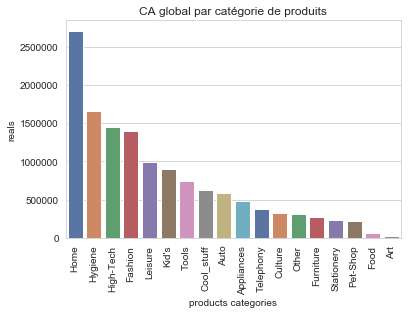

In [168]:
# Visualisation
sns.barplot(x=ca_global_by_cat.index, y=ca_global_by_cat, palette="deep")

plt.xlabel('products categories')
plt.ylabel('reals')
plt.xticks(rotation=90)
plt.title('CA global par catégorie de produits')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/CA global par catégories.png', dpi=200, bbox_inches='tight')
plt.show()

***

C:\Users\Yop1001\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


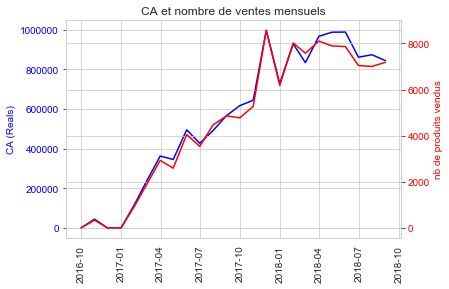

In [169]:
# Evolution mensuelle du CA et du volume de ventes
plt.tick_params(axis="y", labelcolor="b")
plt.tick_params(axis="x", rotation=90)
line1 = sns.lineplot(x=data_by_month.index, y=data_by_month['sum'], color='blue', data=data_by_month)
plt.ylabel("CA (Reals)", color="b")
plt.xlabel('')

plt.twinx()
plt.tick_params(axis="y", labelcolor="r")
plt.tick_params(axis="x", rotation=90)
line2 = sns.lineplot(x=data_by_month.index, y=data_by_month['count'], color="red", data=data_by_month)
plt.ylabel("nb de produits vendus", color="r")

plt.title('CA et nombre de ventes mensuels')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Evolution mensuelle CA et volume des ventes.png', dpi=200, bbox_inches='tight')
plt.show()

***

In [170]:
# Distribution des ventes par mois
sells_by_month

8     12038
5     11913
7     11478
3     11029
6     10579
4     10486
2      9463
1      8971
11     8564
12     6182
10     5617
9      4779
Name: month, dtype: int64

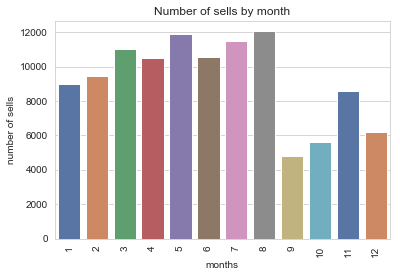

In [171]:
# Visualisation
sns.barplot(x=sells_by_month.index, y=sells_by_month, palette="deep")

plt.xlabel('months')
plt.ylabel('number of sells')
plt.xticks(rotation=90)
plt.title('Number of sells by month')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Sells by month.png', dpi=200, bbox_inches='tight')
plt.show()

Etonnament les ventes se font majoritairement de mars à aout et non avant Noèl même si les ventes au mois de novembre sont significatives

***

In [172]:
# Distribution des ventes par weekday name
sells_by_weekday_name

Monday       18131
Tuesday      17966
Wednesday    17349
Thursday     16565
Friday       15864
Sunday       13222
Saturday     12002
Name: weekday_name, dtype: int64

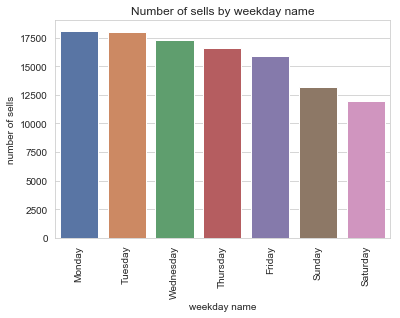

In [173]:
# Visualisation
sns.barplot(x=sells_by_weekday_name.index, y=sells_by_weekday_name, palette="deep")

plt.xlabel('weekday name')
plt.ylabel('number of sells')
plt.xticks(rotation=90)
plt.title('Number of sells by weekday name')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Sells by weekday name.png', dpi=200, bbox_inches='tight')
plt.show()

In [174]:
# Distribution des ventes par heure
sells_by_hour.head()

16    7527
14    7463
11    7327
13    7302
15    7288
Name: hour, dtype: int64

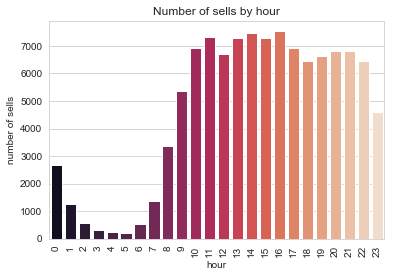

In [175]:
# Visualisation
sns.barplot(x=sells_by_hour.index, y=sells_by_hour, palette="rocket")

plt.xlabel('hour')
plt.ylabel('number of sells')
plt.xticks(rotation=90)
plt.title('Number of sells by hour')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Sells by hour.png', dpi=200, bbox_inches='tight')
plt.show()

***

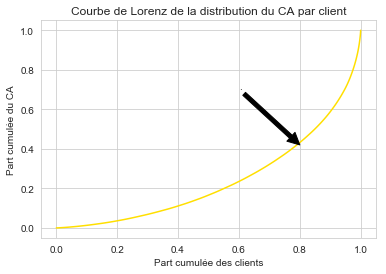

In [176]:
# Distribution du CA par client (courbe de Lorenz)
dep = data_customers['total_spent'].values
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0], lorenz) # La courbe de Lorenz commence à 0
plt.plot(np.linspace(0, 1, len(lorenz)), lorenz, drawstyle='steps-post', color=golden_brazil)

plt.xlabel('Part cumulée des clients')
plt.ylabel('Part cumulée du CA')
plt.title('Courbe de Lorenz de la distribution du CA par client')
plt.annotate('.', xy=(0.8, 0.42), xytext=(0.6, 0.7), arrowprops={'color':'black'})

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Courbe de Lorenz de la distribution du CA par client.png', dpi=200, bbox_inches='tight')

plt.show()

In [177]:
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

0.5220520519418641

**60 % du CA fait par 20% des clients**

***

In [178]:
# Distribution du CA par produit (courbe de Lorenz)
ca_by_product = data.groupby('product_id')['price'].sum()
ca_by_product.head()

product_id
00066f42aeeb9f3007548bb9d3f33c38    101.65
00088930e925c41fd95ebfe695fd2655    129.90
0009406fd7479715e4bef61dd91f2462    229.00
000b8f95fcb9e0096488278317764d19    117.80
000d9be29b5207b54e86aa1b1ac54872    199.00
Name: price, dtype: float64

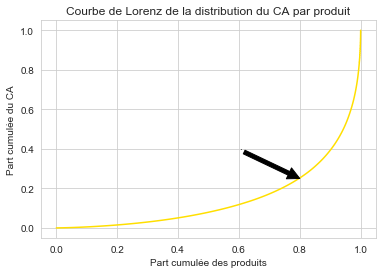

In [179]:
dep = ca_by_product
lorenz = np.cumsum(np.sort(dep)) / dep.sum()
lorenz = np.append([0],lorenz) # La courbe de Lorenz commence à 0
plt.plot(np.linspace(0, 1, len(lorenz)), lorenz, drawstyle='steps-post', color=golden_brazil)

plt.xlabel('Part cumulée des produits')
plt.ylabel('Part cumulée du CA')
plt.title('Courbe de Lorenz de la distribution du CA par produit')
plt.annotate('.', xy=(0.8, 0.25), xytext=(0.6, 0.4), arrowprops={'color':'black'})

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Courbe de Lorenz de la distribution du CA par produit.png', dpi=200, bbox_inches='tight')

plt.show()

In [180]:
aire_ss_courbe = lorenz[:-1].sum()/len(lorenz) # aire sous la courbe de Lorenz. La dernière valeur ne participe pas à l'aire, d'où "[:-1]"
S = 0.5 - aire_ss_courbe # aire entre la 1e bissectrice et la courbe de Lorenz
gini = 2*S
gini

0.707924304974916

**20% des produits génèrent 75% du CA**

<a class="anchor" id="etude_produits"></a>
***
## 8.3. Etude des produits

In [181]:
# Répartition des produits par catégorie - idem immeubles P4
products_by_cat = data['main_category'].value_counts()
products_by_cat.head()

Home         28769
Hygiene      13139
High-Tech    12018
Leisure       8647
Fashion       8634
Name: main_category, dtype: int64

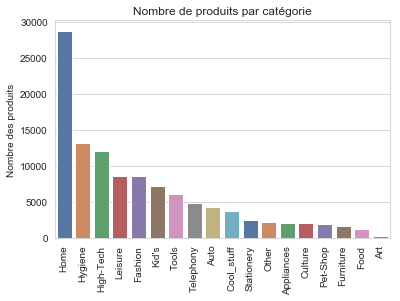

In [182]:
# Visualisation
sns.barplot(x=products_by_cat.index, y=products_by_cat, palette="deep")
plt.ylabel('Nombre des produits')
plt.xlabel('')
plt.xticks(rotation=90)
plt.title('Nombre de produits par catégorie')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Nombre de produits par catégorie.png', dpi=200, bbox_inches='tight')
plt.show()

***

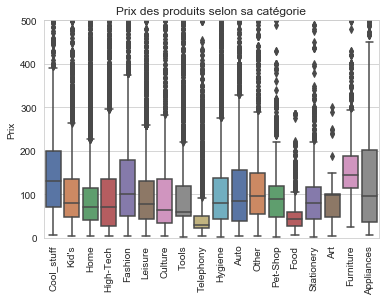

In [183]:
# Répartition des prix par catégories - boxplot
sns.boxplot(x="main_category", y="price", data=data, palette="deep")

plt.ylabel('Prix')
plt.xlabel('')
plt.xticks(rotation=90)
plt.title('Prix des produits selon sa catégorie')
plt.ylim(0, 500)

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Prix des produitsselon sa categorie.png', dpi=200, bbox_inches='tight')
plt.show()

***

In [184]:
# Produits les plus vendus 
data['product_id'].value_counts().head(10)

aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    490
422879e10f46682990de24d770e7f83d    487
368c6c730842d78016ad823897a372db    391
389d119b48cf3043d311335e499d9c6b    390
53759a2ecddad2bb87a079a1f1519f73    375
d1c427060a0f73f6b889a5c7c61f2ac4    341
53b36df67ebb7c41585e8d54d6772e08    323
154e7e31ebfa092203795c972e5804a6    292
3dd2a17168ec895c781a9191c1e95ad7    274
Name: product_id, dtype: int64

<a class="anchor" id="etude_clients"></a>
***
## 8.4. Etude des comportements clients

In [185]:
# Sauvegarde de la table data_customers (pour geoloc)
# data.to_excel("data_customers.xlsx")

In [186]:
# Géolocalisation des clients
#from IPython.display import IFrame
IFrame('https://yop1001.carto.com/builder/2a667e2b-b1ac-4aab-85cb-1a6b73c440f9/embed', width=700, height=700)

[Lien de la carte](https://yop1001.carto.com/builder/2a667e2b-b1ac-4aab-85cb-1a6b73c440f9/embed)

***

In [187]:
# Distribution des articles achetés 
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,review_score,nb_of_comments,%_of_comments,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,nb_of_sellers_used,sellers_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,5.0,1,100.0,7787,cajamar,SP,-23.335331,-46.828647,1,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,4.0,0,0.0,6053,osasco,SP,-23.567395,-46.792957,1,0.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,3.0,0,0.0,88115,sao jose,SC,-27.543787,-48.625680,1,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,4.0,1,100.0,66812,belem,PA,-1.311011,-48.482884,1,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,5.0,0,0.0,18040,sorocaba,SP,-23.504368,-47.466156,1,0.0


In [188]:
nb_of_items_bought_distribution = data_customers['nb_of_items_bought'].value_counts()
nb_of_items_bought_distribution.head()

1    81932
2     8640
3     1735
4      685
5      276
Name: nb_of_items_bought, dtype: int64

In [189]:
nb_of_items_bought_distribution[1]

81932

In [190]:
# Pourcentage de clients one-shot
single_item_customers = ((nb_of_items_bought_distribution[1]) / data_customers.shape[0])*100
single_item_customers = round(single_item_customers,2)
single_item_customers

87.52

In [191]:
# Nombre de clients ayant acheté qu'une fois
print('{}% des clients n\'ont commandé qu\'un seul article.'.format(single_item_customers))

87.52% des clients n'ont commandé qu'un seul article.


***

In [192]:
# Nb d'articles par panier
items_by_basket = data.groupby('order_id')['product_id'].count()
items_by_basket.head()

order_id
00010242fe8c5a6d1ba2dd792cb16214    1
00018f77f2f0320c557190d7a144bdd3    1
000229ec398224ef6ca0657da4fc703e    1
00024acbcdf0a6daa1e931b038114c75    1
00042b26cf59d7ce69dfabb4e55b4fd9    1
Name: product_id, dtype: int64

In [193]:
items_by_basket.mean()

1.148250736396052

In [194]:
items_by_basket.median()

1.0

In [195]:
# Nombre de panier contenant un seul article
items_by_basket.loc[items_by_basket == 1].count()

86679

In [196]:
# Pourcentage de paniers contenant 1 seul article
((items_by_basket.loc[items_by_basket == 1].count() / items_by_basket.size)*100).round(2)

89.59

No handles with labels found to put in legend.


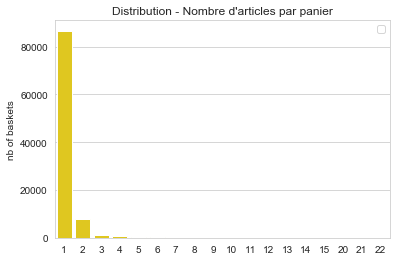

In [197]:
# Distribution de la variable
items_by_basket = items_by_basket.value_counts()

# Visualisation
sns.barplot(x=items_by_basket.index, y=items_by_basket, color=golden_brazil)

plt.title('Distribution - Nombre d\'articles par panier')
plt.xlabel('')
plt.ylabel('nb of baskets')
plt.legend()

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Nombre d\'articles par panier.png', dpi=200, bbox_inches='tight')
plt.show()


***

In [198]:
# Valeur par panier
reals_by_basket = data.groupby('order_id')['price'].sum()
reals_by_basket.head()

order_id
00010242fe8c5a6d1ba2dd792cb16214     58.90
00018f77f2f0320c557190d7a144bdd3    239.90
000229ec398224ef6ca0657da4fc703e    199.00
00024acbcdf0a6daa1e931b038114c75     12.99
00042b26cf59d7ce69dfabb4e55b4fd9    199.90
Name: price, dtype: float64

In [199]:
reals_by_basket.mean()

138.1262002998491

In [200]:
reals_by_basket.median()

86.99

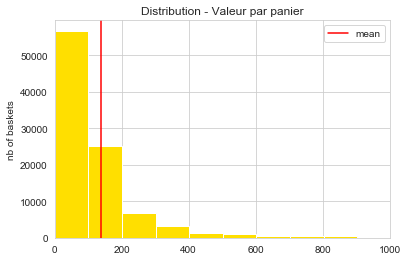

In [201]:
# Visualisation
sns.distplot(reals_by_basket, kde=False, bins=134, color=golden_brazil, hist_kws={'alpha':1})
plt.axvline(reals_by_basket.mean(), color='red', linestyle='-', label='mean')

plt.title('Distribution - Valeur par panier')
plt.xlabel('')
plt.ylabel('nb of baskets')
plt.legend()
plt.xlim(1, 1000)

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Valeur par panier.png', dpi=200, bbox_inches='tight')
plt.show()

***

In [202]:
# Distribution du nombre de panier par client
basket_distribution = data_customers['nb_of_baskets'].value_counts()
basket_distribution.head()

1    90792
2     2596
3      181
4       30
5        9
Name: nb_of_baskets, dtype: int64

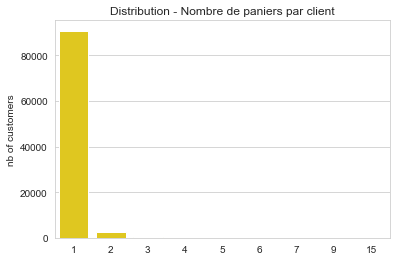

In [203]:
# Visualisation
sns.barplot(x=basket_distribution.index, y=basket_distribution, color=golden_brazil)

plt.title('Distribution - Nombre de paniers par client')
plt.xlabel('')
plt.ylabel('nb of customers')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Nombre de panier par client.png', dpi=200, bbox_inches='tight')
plt.show()

***

In [204]:
# Fréquence des achats

# Nombre de clients ayant commandé qu'une seule fois
data_customers.loc[data_customers['nb_of_baskets'] == 1].shape[0]

90792

In [205]:
# Pourcentage de clients one-shot
one_shot_customers = ((data_customers.loc[data_customers['nb_of_baskets'] == 1].shape[0]) / data_customers.shape[0])*100
one_shot_customers = round(one_shot_customers,2)
one_shot_customers

96.98

In [206]:
# Nombre de clients ayant acheté qu'une fois
print('{}% des clients n\'ont commandé qu\'une seule fois.'.format(one_shot_customers))

96.98% des clients n'ont commandé qu'une seule fois.


***

In [207]:
# Nombre de clients ayant commandé + d'une fois
regular_customers = data_customers.loc[data_customers['nb_of_baskets'] != 1]
regular_customers.shape

(2824, 39)

In [208]:
# Distribution du nombre de panier - loyal customers
basket_distribution_2 = regular_customers['nb_of_baskets'].value_counts()
basket_distribution_2.head()

2    2596
3     181
4      30
5       9
7       3
Name: nb_of_baskets, dtype: int64

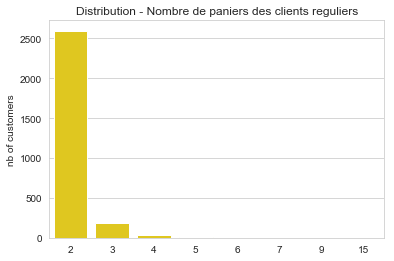

In [209]:
# Visualisation
sns.barplot(x=basket_distribution_2.index, y=basket_distribution_2, color=golden_brazil)

plt.title('Distribution - Nombre de paniers des clients reguliers')
plt.xlabel('')
plt.ylabel('nb of customers')

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Nombre de panier des clients reguliers.png', dpi=200, bbox_inches='tight')
plt.show()

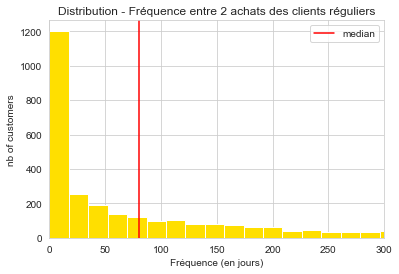

In [210]:
# Visualisation
sns.distplot(regular_customers['mean_purchase_frequency(days)'] , kde=False, color=golden_brazil, hist_kws={'alpha':1})
plt.axvline(regular_customers['mean_purchase_frequency(days)'].mean(), color='red', linestyle='-', label='median')

plt.title('Distribution - Fréquence entre 2 achats des clients réguliers')
plt.xlabel('Fréquence (en jours)')
plt.ylabel('nb of customers')
plt.legend()
plt.xlim(0, 300)

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Fréquence entre 2 achats des clients réguliers.png', dpi=200, bbox_inches='tight')
plt.show()

***

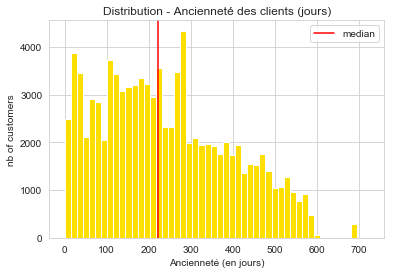

In [211]:
# Ancienneté des clients

# Visualisation
sns.distplot(data_customers['anciennete'] , kde=False, color=golden_brazil, hist_kws={'alpha':1})
plt.axvline(data_customers['anciennete'].median(), color='red', linestyle='-', label='median')

plt.title('Distribution - Ancienneté des clients (jours)')
plt.xlabel('Ancienneté (en jours)')
plt.ylabel('nb of customers')
plt.legend()
#plt.xlim(0, 300)

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Ancienneté des clients.png', dpi=200, bbox_inches='tight')
plt.show()

***

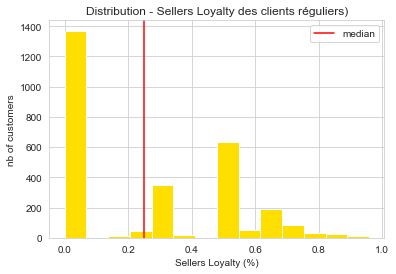

In [212]:
# sellers_loyalty des regular_customers

# Visualisation
sns.distplot(regular_customers['sellers_loyalty'] , kde=False, color=golden_brazil, hist_kws={'alpha':1})
plt.axvline(regular_customers['sellers_loyalty'].median(), color='red', linestyle='-', label='median')

plt.title('Distribution - Sellers Loyalty des clients réguliers)')
plt.xlabel('Sellers Loyalty (%)')
plt.ylabel('nb of customers')
plt.legend()
#plt.xlim(0, 300)

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/Sellers Loyalty des clients reguliers.png', dpi=200, bbox_inches='tight')
plt.show()

je ne sais pas interpréter cette visualisation

***

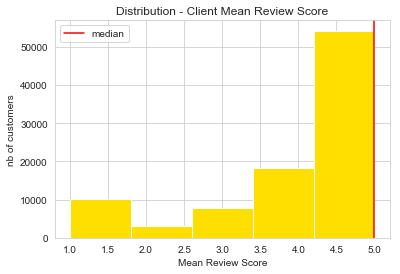

In [227]:
# Review Score

# Visualisation
sns.distplot(data_customers['review_score'] , bins =5, kde=False, color=golden_brazil, hist_kws={'alpha':1})
plt.axvline(data_customers['review_score'].median(), color='red', linestyle='-', label='median')

plt.title('Distribution - Client Mean Review Score')
plt.xlabel('Mean Review Score')
plt.ylabel('nb of customers')
plt.legend()

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/client mean review score.png', dpi=200, bbox_inches='tight')
plt.show()

In [228]:
data_customers['review_score'].mean()

4.1007146696011345

***

In [214]:
# Nombre de clients qui n'ont laissé aucun commentaire
nb_of_clients_no_comment = data_customers.loc[data_customers['%_of_comments'] == 0].shape[0]
nb_of_clients_no_comment

54483

In [215]:
# % de clients qui n'ont jamais mis de commentaire
(nb_of_clients_no_comment / data_customers.shape[0])*100

58.19838489147154

In [216]:
# Nombre de clients REGULIERS qui n'ont laissé aucun commentaire
nb_of_regular_clients_no_comment = regular_customers.loc[regular_customers['%_of_comments'] == 0].shape[0]
nb_of_regular_clients_no_comment

1327

In [217]:
# % de clients REGULIERS qui n'ont jamais mis de commentaire
(nb_of_regular_clients_no_comment / regular_customers.shape[0])*100

46.99008498583569

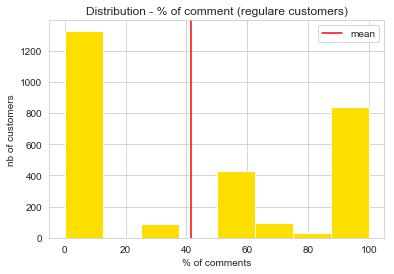

In [218]:
# %_of_comments des regular_customers

# Visualisation
sns.distplot(regular_customers['%_of_comments'] , kde=False, color=golden_brazil, hist_kws={'alpha':1})
plt.axvline(regular_customers['%_of_comments'].mean(), color='red', linestyle='-', label='mean')

plt.title('Distribution - % of comment (regulare customers)')
plt.xlabel('% of comments')
plt.ylabel('nb of customers')
plt.legend()

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/% of comment regular customers.png', dpi=200, bbox_inches='tight')
plt.show()

<a class="anchor" id="correlations"></a>
***
## 8.5. Corrélations

In [219]:
data_customers.head()

,customer_unique_id,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),time_length,oldest_purchase,anciennete,purchase_frequency,mean_purchase_frequency(days),...,review_score,nb_of_comments,%_of_comments,customer_zip_code_prefix,customer_city,customer_state,geolocation_lat,geolocation_lng,nb_of_sellers_used,sellers_loyalty
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,1,1.0,0 days,2018-05-10 10:56:27,111,NaT,NaN,...,5.0,1,100.0,7787,cajamar,SP,-23.335331,-46.828647,1,0.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,1,1.0,0 days,2018-05-07 11:11:27,114,NaT,NaN,...,4.0,0,0.0,6053,osasco,SP,-23.567395,-46.792957,1,0.0
2,0000f46a3911fa3c0805444483337064,1,69.00,1,1.0,0 days,2017-03-10 21:05:03,536,NaT,NaN,...,3.0,0,0.0,88115,sao jose,SC,-27.543787,-48.625680,1,0.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,1,1.0,0 days,2017-10-12 20:29:41,320,NaT,NaN,...,4.0,1,100.0,66812,belem,PA,-1.311011,-48.482884,1,0.0
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,1,1.0,0 days,2017-11-14 19:45:42,287,NaT,NaN,...,5.0,0,0.0,18040,sorocaba,SP,-23.504368,-47.466156,1,0.0


In [220]:
# Corrélation hors catégories produits
data_customers_correlation = data_customers[['nb_of_items_bought', 'total_spent', 'nb_of_baskets', 'items_by_basket(mean)', 'anciennete', 'td', 'review_score', 'nb_of_comments', 'geolocation_lat',
       'geolocation_lng']]

In [221]:
# Correlation
corr_table = data_customers_correlation.corr()
corr_table.style.background_gradient()

C:\Users\Yop1001\Anaconda3\lib\site-packages\matplotlib\colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,nb_of_items_bought,total_spent,nb_of_baskets,items_by_basket(mean),anciennete,td,review_score,nb_of_comments,geolocation_lat,geolocation_lng
nb_of_items_bought,1,0.200939,0.466497,0.883538,0.0339719,nan,-0.0973575,0.457266,-0.0187461,-0.0142536
total_spent,0.200939,1,0.119102,0.16283,0.0121215,nan,-0.0376466,0.112442,0.0481797,0.0133515
nb_of_baskets,0.466497,0.119102,1,0.0520866,0.0773796,nan,0.00871119,0.15253,-0.00977435,-0.00244472
items_by_basket(mean),0.883538,0.16283,0.0520866,1,0.00337352,nan,-0.118507,0.448981,-0.0162749,-0.0151731
anciennete,0.0339719,0.0121215,0.0773796,0.00337352,1,nan,-0.0158141,0.0309449,0.0233818,0.00255071
td,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
review_score,-0.0973575,-0.0376466,0.00871119,-0.118507,-0.0158141,nan,1,-0.274365,-0.0469631,-0.0567596
nb_of_comments,0.457266,0.112442,0.15253,0.448981,0.0309449,nan,-0.274365,1,0.0343249,0.0317062
geolocation_lat,-0.0187461,0.0481797,-0.00977435,-0.0162749,0.0233818,nan,-0.0469631,0.0343249,1,0.453514
geolocation_lng,-0.0142536,0.0133515,-0.00244472,-0.0151731,0.00255071,nan,-0.0567596,0.0317062,0.453514,1


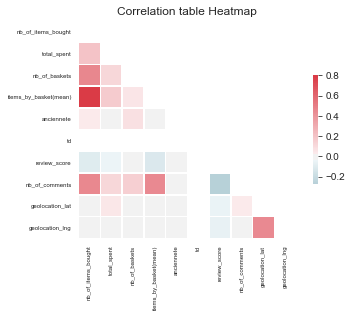

In [222]:
# Draw the heatmap with the mask and correct aspect ratio
# Sources : https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_table, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_table, mask=mask, cmap=cmap, vmax=0.8, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation table Heatmap')
plt.xticks(rotation=90, size=6)
plt.yticks(size=6)

plt.savefig('02 - Graphs/00 - Nettoyage et Exploration/correlation_table_heatmap.png', dpi=200, bbox_inches='tight')
plt.show()

=> RAS

***

In [223]:
# Sauvegarde de la table data_customers
data_customers.to_csv("data_customers.csv")

# Sauvegarde des tables pour predire la maintenance
data_customers_1y.to_csv("data_customers_1y.csv")
data_customers_1y_3m.to_csv("data_customers_1y_3m.csv")
data_customers_1y_6m.to_csv("data_customers_1y_6m.csv")
data_customers_1y_9m.to_csv("data_customers_1y_9m.csv")
data_customers_2y.to_csv("data_customers_2y.csv")

In [224]:
# Sauvegarde de la table data
# data.to_excel("data.xlsx")

***

In [225]:
# Voir toutes les variables
%whos 

Variable                           Type                       Data/Info
-----------------------------------------------------------------------
IFrame                             type                       <class 'IPython.lib.display.IFrame'>
S                                  float64                    0.353962152487458
aire_ss_courbe                     float64                    0.14603784751254204
basket_distribution                Series                     1     90792\n2      2596\<...>_of_baskets, dtype: int64
basket_distribution_2              Series                     2     2596\n3      181\n4<...>_of_baskets, dtype: int64
baskets                            DataFrame                                       cust<...>n[93616 rows x 2 columns]
ca_by_product                      Series                     product_id\n00066f42aeeb9<...>th: 32105, dtype: float64
ca_global_by_cat                   Series                     main_category\nHome      <...>me: price, dtype: float64
cat_b

***
[Top de la page](#top)